In [24]:
import cassiopeia as cas
import pandas as pd
import pickle as pic
from tqdm.notebook import tqdm
import numpy as np
import inverse_whd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from benchmark_module import BenchmarkModule
import os
import matplotlib.pyplot as plt

# Base parameters, no fitness
in_folder = "/data/yosef2/users/richardz/projects/CassiopeiaV2-Reproducibility/trees/exponential_plus_c/400cells/no_fit/char40/"
out_folder = "./data/"

# Alternative Data. Must re-implement get_cm() or use the class GroundTruthCMBM()
in_folder_2 = "/home/eecs/ivalexander13/datadir/simulation_data/trees4/exponential_plus_c/no_fit/cells400/mutrate0.5/char40/states100/"
in_folder_3 = "/home/eecs/ivalexander13/datadir/simulation_data/trees4/exponential_plus_c/no_fit/cells2000/mutrate0.5/char40/states100/"


# NJ Plain

In [3]:
nj_plain = BenchmarkModule(
    test_name = "nj_plain",
    gt_trees_dir = in_folder,
    numtrees = 50,
    out_basefolder = out_folder,
)

nj_plain.reconstruct(overwrite=False)
nj_plain.evaluate(overwrite=False)

Skipping reconstruction 49: 100%|██████████| 50/50 [00:00<00:00, 535.45it/s]


# NJ Vanilla; 400 cells, no missing data, real time


In [27]:
class GroundTruthCMBM(BenchmarkModule):
    def get_cm(self, i):
        gt_tree = self.get_gt_tree(i)
        cm = gt_tree.character_matrix

        return cm

In [16]:
in_folder_iwhd_2 = "/home/eecs/ivalexander13/datadir/simulation_data/trees4/exponential_plus_c/no_fit/cells400/mutrate0.5/char40/states100/"

nj_plain_2 = GroundTruthCMBM(
    test_name = "nj_plain_2",
    gt_trees_dir = in_folder_2,
    numtrees = 50,
    out_basefolder = out_folder,
)

nj_plain_2.reconstruct(overwrite=True)
nj_plain_2.evaluate(overwrite=True)

Evaluating tree 49: 100%|██████████| 50/50 [05:36<00:00,  6.73s/it]


# SNJ Plain

In [35]:
snj_plain = BenchmarkModule(
    test_name = "snj_plain",
    solver=cas.solver.SpectralNeighborJoiningSolver(add_root = True),
    numtrees=50,
    gt_trees_dir = in_folder,
    out_basefolder = out_folder,
)

snj_plain.reconstruct(overwrite=False, collapse_mutationless_edges=True)
snj_plain.evaluate(overwrite=False)

Evaluating tree 49: 100%|██████████| 50/50 [05:24<00:00,  6.49s/it]


# NJ with Inverse WHD; 400 cells, with missing data, real time

In [30]:
class IWHDBenchmarkModule(BenchmarkModule):
    def __init__(self, test_name, gt_trees_dir, numtrees, out_basefolder):
        super().__init__(
            test_name = test_name,
            gt_trees_dir = gt_trees_dir,
            numtrees = numtrees,
            out_basefolder = out_basefolder,
        )

        # state_distribution = pickle.load(open("/data/yosef2/users/richardz/projects/CassiopeiaV2-Reproducibility/priors/states100.pkl", "rb"))
        numstates = 100
        state_distribution = dict(enumerate([1 / numstates] * numstates, 1))
        self.q = np.sum(np.array([*state_distribution.values()])**2)

    def run_solver(self, i, cm, collapse_mutationless_edges):
        # Initialize output recon tree
        recon_tree = cas.data.CassiopeiaTree(
            character_matrix=cm, 
            missing_state_indicator = -1
            )

        # Get gt tree
        gt_tree = self.get_gt_tree(i)
        total_time = gt_tree.get_time(gt_tree.leaves[0])

        # Get iwhd dissim function
        def inv_whd(
            s1,
            s2,
            missing_state_indicator=-1,
            weights=None,
        ) -> float:
            
            # WHD redefined
            whd = cas.solver.dissimilarity_functions.weighted_hamming_distance(s1, s2, missing_state_indicator, weights)
            
            # calc inv whd
            return 2 * inverse_whd.ewhd_inv(
                num_sites=40, 
                mut_rate=np.log(1 - 0.5)/(-1 * total_time), 
                collision_rate=self.q, 
                whd=whd, 
                time=total_time, 
                error_tolerance=0.001
            )
    
        # Instantiate Solver
        self.solver = cas.solver.NeighborJoiningSolver(add_root = True, dissimilarity_function=inv_whd) 
        self.solver.solve(recon_tree, collapse_mutationless_edges = collapse_mutationless_edges)
        
        return recon_tree.get_newick()  

    def get_cm(self, i):
        gt_tree = self.get_gt_tree(i)
        cm = gt_tree.character_matrix

        return cm     

In [17]:
nj_iwhd_1 = IWHDBenchmarkModule(
    test_name = "nj_iwhd_1",
    gt_trees_dir = in_folder,
    numtrees=50,
    out_basefolder = out_folder,
)

nj_iwhd_1.reconstruct(overwrite=False)
nj_iwhd_1.evaluate(overwrite=False)

Evaluating tree 49: 100%|██████████| 50/50 [05:23<00:00,  6.47s/it]


# NJ with Inverse WHD; 400 cells, no missing data, real time

Make sure to run the IWHDBenchmarkModule cell above

In [31]:
in_folder_iwhd_2 = "/home/eecs/ivalexander13/datadir/simulation_data/trees4/exponential_plus_c/no_fit/cells400/mutrate0.5/char40/states100/"

nj_iwhd_2 = IWHDBenchmarkModule(
    test_name = "nj_iwhd_2",
    gt_trees_dir = in_folder_2,
    numtrees=50,
    out_basefolder = out_folder,
)

nj_iwhd_2.reconstruct(overwrite=True)
nj_iwhd_2.evaluate(overwrite=True)

Evaluating tree 49: 100%|██████████| 50/50 [05:24<00:00,  6.50s/it]


# NJ with Inverse WHD; 2000 cells, no missing data, real time

In [ ]:
in_folder_iwhd_3 = "/home/eecs/ivalexander13/datadir/simulation_data/trees4/exponential_plus_c/no_fit/cells2000/mutrate0.5/char40/states100/"

nj_iwhd_3 = IWHDBenchmarkModule(
    test_name = "nj_iwhd_3",
    gt_trees_dir = in_folder_2,
    numtrees=50,
    out_basefolder = out_folder,
)

nj_iwhd_3.reconstruct(overwrite=False)
nj_iwhd_3.evaluate(overwrite=False)

# NJ with True Distance

In [34]:
nj_true_dist = TrueDistBM(
    test_name = "nj_true_dist",
    solver=cas.solver.SpectralNeighborJoiningSolver(add_root = True),
    numtrees=50,
    gt_trees_dir = in_folder,
    out_basefolder = out_folder,
)

nj_true_dist.reconstruct(overwrite=True, collapse_mutationless_edges=False)
nj_true_dist.evaluate(overwrite=True)

Evaluating tree 49: 100%|██████████| 50/50 [05:29<00:00,  6.59s/it]


# SNJ with Exp True Distance

In [32]:
class TrueDistBM(BenchmarkModule):
    def run_solver(self, i, cm, collapse_mutationless_edges):
        # Initialize output recon tree
        recon_tree = cas.data.CassiopeiaTree(
            character_matrix=cm, 
            missing_state_indicator = -1
            )

        # Get gt tree
        gt_tree = self.get_gt_tree(i)

        # Get iwhd dissim function
        dists = pd.DataFrame(columns=gt_tree.leaves, index=gt_tree.leaves)
        for leaf in gt_tree.leaves:
            dists[leaf] = gt_tree.get_distances(leaf, leaves_only=True).values()
            
        dists = np.exp(dists)
            
        recon_tree.set_dissimilarity_map(dists)
    
        # Instantiate Solver
        self.solver.solve(recon_tree, collapse_mutationless_edges = collapse_mutationless_edges)
        
        return recon_tree.get_newick()

In [33]:
snj_true_dist = TrueDistBM(
    test_name = "snj_true_dist",
    solver=cas.solver.SpectralNeighborJoiningSolver(add_root = True),
    gt_trees_dir = in_folder,
    numtrees=50,
    out_basefolder = out_folder,
)

snj_true_dist.reconstruct(overwrite=True, collapse_mutationless_edges=False)
snj_true_dist.evaluate(overwrite=True)

Evaluating tree 49: 100%|██████████| 50/50 [05:25<00:00,  6.51s/it]


# NJ Yaffe

In [ ]:
#!pip install https://github.com/aizeny/snj
import spectraltree
from dendropy import TaxonNamespace

class NJYaffeBM(BenchmarkModule):
    def run_solver(self, i, cm, collapse_mutationless_edges):
        # Initialize output recon tree
        recon_tree = cas.data.CassiopeiaTree(
            character_matrix=cm, 
            missing_state_indicator = -1
            )

        # Reconstruct tree in OG mode, then convert to CassiopeiaTree
        namespace = TaxonNamespace(cm.index)

        taxa_meta = spectraltree.TaxaMetadata(
            namespace,
            [i for i in namespace] 
        )
        nj = spectraltree.NeighborJoining(spectraltree.JC_similarity_matrix)
        solved_newick = str(nj(cm.values, taxa_meta)) + ';'

        recon_tree.populate_tree(solved_newick)
        recon_tree.collapse_mutationless_edges(collapse_mutationless_edges)
    
        return recon_tree.get_newick()

In [ ]:
nj_yaffe = BenchmarkModule(
    test_name = "nj_yaffe",
    numtrees=50,
    gt_trees_dir = in_folder,
    out_basefolder = out_folder,
)

nj_yaffe.reconstruct(overwrite=True, collapse_mutationless_edges=True)
nj_yaffe.evaluate(overwrite=True)

# SNJ Yaffe

In [19]:
#!pip install https://github.com/aizeny/snj
import spectraltree 
from dendropy import TaxonNamespace

class SNJYaffeBM(BenchmarkModule):
    def run_solver(self, i, cm, collapse_mutationless_edges):
        # Initialize output recon tree
        recon_tree = cas.data.CassiopeiaTree(
            character_matrix=cm, 
            missing_state_indicator = -1
            )

        # Reconstruct tree in OG mode, then convert to CassiopeiaTree
        namespace = TaxonNamespace(cm.index)

        taxa_meta = spectraltree.TaxaMetadata(
            namespace,
            [i for i in namespace] 
        )
        snj = spectraltree.SpectralNeighborJoining(spectraltree.JC_similarity_matrix)
        solved_newick = str(snj(cm.values, taxa_meta)) + ';'

        recon_tree.populate_tree(solved_newick)
        recon_tree.collapse_mutationless_edges(collapse_mutationless_edges)
    
        return recon_tree.get_newick()

In [ ]:
snj_yaffe = BenchmarkModule(
    test_name = "snj_yaffe",
    numtrees=50,
    gt_trees_dir = in_folder,
    out_basefolder = out_folder,
)

snj_yaffe.reconstruct(overwrite=True)
snj_yaffe.evaluate(overwrite=True)

# STDR Yaffe

In [ ]:
#!pip install https://github.com/aizeny/snj
import spectraltree
from dendropy import TaxonNamespace

class STDRYaffeBM(BenchmarkModule):
    def run_solver(self, i, cm, collapse_mutationless_edges):
        # Initialize output recon tree
        recon_tree = cas.data.CassiopeiaTree(
            character_matrix=cm, 
            missing_state_indicator = -1
            )

        # Reconstruct tree in OG mode, then convert to CassiopeiaTree
        namespace = TaxonNamespace(cm.index)

        taxa_meta = spectraltree.TaxaMetadata(
            namespace,
            [i for i in namespace] 
        )
        stdr_nj = spectraltree.STDR(spectraltree.NeighborJoining,spectraltree.JC_similarity_matrix)
        solved_newick = str(stdr_nj(cm.values, taxa_meta)) + ';'

        recon_tree.populate_tree(solved_newick)
        recon_tree.collapse_mutationless_edges(collapse_mutationless_edges)
    
        return recon_tree.get_newick()

In [ ]:
stdr_yaffe = BenchmarkModule(
    test_name = "stdr_yaffe",
    numtrees=50,
    gt_trees_dir = in_folder,
    out_basefolder = out_folder,
)

stdr_yaffe.reconstruct(overwrite=True, collapse_mutationless_edges=True)
stdr_yaffe.evaluate(overwrite=True)

# Plotting

In [36]:
# Params
test_names = [
    ("nj_true_dist", "NJ TrueDist"),
    ("nj_plain", "NJ Vanilla"),
    ("nj_iwhd_1", "NJ iWHD: 400 cells, const time, w/ missing data"),
    ("nj_plain_2", "NJ Vanilla: 400 cells, real time, w/o missing data"),
    ("nj_iwhd_2", "NJ iWHD: 400 cells, real time, w/o missing data"),
    # ("nj_iwhd_3", "NJ iWHD: 2000 cells, real time, w/o missing data"),
    ("nj_yaffe", "NJ Yaffe"),
    ("snj_plain", "SNJ Vanilla"),
    # ("snj_true_dist", "SNJ TrueDist"),
    # ("snj_yaffe", "SNJ Yaffe"),
    # ("stdr_yaffe", "STDR Yaffe"),
]

test_names.reverse()

In [37]:
# Collect metrics
metrics_df = pd.DataFrame()
for name, _ in test_names:
    metrics_df[f"RF__{name}"] = pd.read_csv(os.path.join(
        out_folder, 
        f"{name}.rf.csv"
        ))['NormalizedRobinsonFoulds']
    metrics_df[f"triplets__{name}"] = pd.read_csv(os.path.join(
        out_folder,
        f"{name}.triplets.csv"
        ))['TripletsCorrect']

<Figure size 432x288 with 0 Axes>

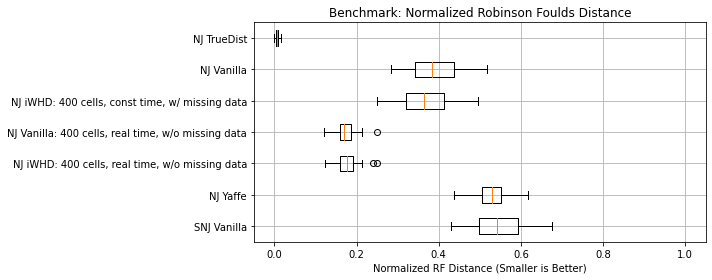

<Figure size 432x288 with 0 Axes>

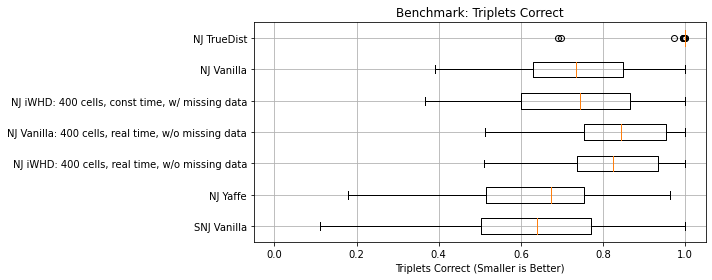

In [38]:
# Plot metrics
rf_vars = {
    'prefix': 'RF__',
    'title': 'Benchmark: Normalized Robinson Foulds Distance',
    'x_label': 'Normalized RF Distance (Smaller is Better)',
    'outfile': 'rf_benchmark.png',
}
triplets_vars = {
    'prefix': 'triplets__',
    'title': 'Benchmark: Triplets Correct',
    'x_label': 'Triplets Correct (Smaller is Better)',
    'outfile': 'triplets_benchmark.png',
}

for vars in [rf_vars, triplets_vars]:
    names = []
    yticks = []
    for name, ytick in test_names:
        names.append(metrics_df[vars['prefix'] + name])
        yticks.append(ytick)

    plt.clf()
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.boxplot(names, vert = 0)
    plt.title(vars['title'])
    plt.xlabel(vars['x_label'])
    plt.yticks(list(range(1, len(metrics_df.columns)//2 + 1)), yticks)
    # plt.xlim(0.07, 0.76)
    plt.xlim(-0.05, 1.05)
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(out_folder, vars['outfile']))
    plt.show();